In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join('/Users/cd8607/Documents/Lammps_MD/', 'git_folder', 'Classes'))
import EAM_Fitting_Serial
import Handle_PotFiles
import time
import glob
from scipy.optimize import minimize
os.chdir('/Users/cd8607/Documents/Lammps_MD')
from scipy.integrate import simpson

In [29]:
def he_h_potential(r, zbl):
    D0 = -0.318151 
    D1 = 1.142826 
    D2 = -0.530526 
    D3 = 0.116766 
    sigma = 3.0862 
    e = 0.0006 
    r1 = 0.5 
    r2 = 2.5

    if r < r1:
        return zbl.eval_zbl(r)
    
    elif r1 < r <= r2:
        return D0 + D1/r + D2/r**2 + D3/r**3
    
    else:
        return 4*e*( (sigma/r) **12 - (sigma/r) ** 6)

def Beck1968(r):

    A = 398.7
    a = 0.675
    alpha = 4.390
    beta = 3.746e-4

    return  A*np.exp(-alpha*r - beta*r**6) - (0.869/((r**2 + a**2)**3)) * (1 + ((2.709 + 3*a**2)/(r**2 + a**2)))

zbl_hhe = EAM_Fitting_Serial.ZBL(2, 1)

zbl_whe = EAM_Fitting_Serial.ZBL(74, 2)

zbl_hehe = EAM_Fitting_Serial.ZBL(2, 2)

alat = 3.14221
r = alat * np.array([np.sqrt(5)/4, np.sqrt(3)/2])

print(zbl_whe.eval_zbl(r))
print(zbl_whe.eval_grad(r))
print(zbl_whe.eval_hess(r))


mean = np.array([0.37, 1, -2, 1, -1, 0.5, 0.5, -0.5, 0.5, -0.8, 0, 0, 0.5, 0, 0])

cov = 0.01*np.diag([0.2, 1, 1, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 1, 1, 0.25, 0.5, 0.5])

print(np.random.multivariate_normal(mean=mean, cov=cov))


[2.83461642 0.26500004]
[-7.97867786 -0.581132  ]
[25.17565205  1.37472214]
[ 0.3872225   1.01652609 -1.96559045  0.97838686 -1.0080037   0.44370782
  0.45822391 -0.50715979  0.4705458  -0.74120139  0.0886441   0.26488074
  0.51702629  0.00782989  0.06223279]


In [30]:
he_p = np.sin(np.arange(0, 5))

sort_idx = np.argsort(he_p)

loss = 0

if not (sort_idx == np.arange(len(he_p))).all():
    
    loss = 1000

print( (sort_idx == np.arange(len(he_p))).all() )

False


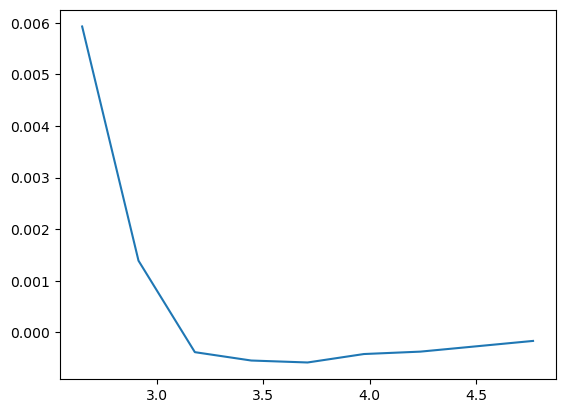

In [31]:
r = 0.52977 * np.array([5, 5.5, 6, 6.5, 7, 7.5, 8, 9])

kb = 8.6173303e-5	

e_K = np.array([68.8, 16.10, -4.48, -6.36, -6.8, -4.9, -4.36, -1.95])

plt.plot(r, kb * e_K)

pairwise_he_he = np.array([ [3.0 , 3812.0],
                            [4.5, 60.0],
                            [5.0, -0.41],
                            [5.6, -11.01],
                            [6.6, -6.25],
                            [7.5, -3.05],
                            [9.0, -0.96], ])
pairwise_he_he[:,0] *= 0.52977
pairwise_he_he[:,1] *= kb


In [32]:
virial_coef_he_he = np.array([
        [2.47734287e+01, 5.94121916e-01],
        [2.92941502e+01, 2.40776488e+00],
        [3.07958539e+01, 3.83040639e+00],
        [3.68588657e+01, 5.40986938e+00],
        [4.17479885e+01, 6.53497823e+00],
        [4.46858331e+01, 7.17968070e+00],
        [4.75019178e+01, 8.38570392e+00],
        [5.37647405e+01, 9.02532656e+00],
        [6.15199008e+01, 9.93664731e+00],
        [6.60125239e+01, 1.03170537e+01],
        [7.25313543e+01, 1.06944122e+01],
        [8.24001392e+01, 1.14797533e+01],
        [9.07328778e+01, 1.17820755e+01],
        [1.17039231e+02, 1.21403483e+01],
        [1.41069613e+02, 1.20965893e+01],
        [1.67450895e+02, 1.21365022e+01],
        [1.93516850e+02, 1.21478229e+01],
        [2.41917917e+02, 1.21190856e+01],
        [2.67315755e+02, 1.20323657e+01],
        [2.91396089e+02, 1.19211176e+01],
        [2.68130785e+02, 1.18153354e+01],
        [3.17493260e+02, 1.16470198e+01],
        [3.69327808e+02, 1.14298383e+01],
        [4.19601366e+02, 1.11111245e+01],
        [4.67439296e+02, 1.10837355e+01],
        [5.70002943e+02, 1.08218509e+01],
        [6.68648934e+02, 1.04696549e+01],
        [7.63553410e+02, 1.01675917e+01],
        [8.72549304e+02, 9.91475627e+00],
        [1.07102569e+03, 9.29054054e+00],
        [1.26456401e+03, 8.73262548e+00],
        [1.47116726e+03, 8.23063465e+00]
        ])

pairwise_h_he = np.column_stack([r, kb * e_K])

print(pairwise_he_he)

[[ 1.58931000e+00  3.28492631e-01]
 [ 2.38396500e+00  5.17039818e-03]
 [ 2.64885000e+00 -3.53310542e-05]
 [ 2.96671200e+00 -9.48768066e-04]
 [ 3.49648200e+00 -5.38583144e-04]
 [ 3.97327500e+00 -2.62828574e-04]
 [ 4.76793000e+00 -8.27263709e-05]]


In [33]:
def loss_he_he(x, eam_fit, virial_ref, pairwise_ref):

    loss = 0

    eam_fit.sample_to_file(x)

    r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

    phi = eam_fit.pot_lammps['He-He'][1:] / r
    
    coef_dict = eam_fit.fit_sample(x)
    
    virial_pot = np.zeros((len(virial_ref), ))
    
    conv = 6.02214e-1

    for i, T in enumerate(virial_ref[:,0]):

        kb = 8.6173303e-5

        beta = 1 / (kb * T)

        phi = np.clip(phi, a_max=10, a_min=-10)
        
        y = ( 1 - np.exp(-beta * phi) ) * r**2

        virial_pot[i] = 2* np.pi * conv * simpson(y, x=r)
        
    loss = np.sum((virial_pot - virial_ref[:,1])**2, axis = 0)

    coef_dict = eam_fit.fit_sample(x)

    ZBL = EAM_Fitting_Serial.ZBL(2, 2)

    poly = EAM_Fitting_Serial.splineval(pairwise_ref[:, 0], coef_dict['He-He'], eam_fit.knot_pts['He-He'])

    zbl = ZBL.eval_zbl(pairwise_ref[:, 0])

    phi_pot = poly + zbl
    
    loss += np.sum((phi_pot - pairwise_ref[:, 1])**2, axis=0)

    return loss

In [34]:
pot, potlines, pot_params = Handle_PotFiles.read_pot('Fitting_Runtime/Potentials/optim.0.eam.alloy')

n_knots = {}
n_knots['He_F'] = 0
n_knots['He_p'] = 0
n_knots['W-He'] = 0
n_knots['He-He'] = 4
n_knots['H-He'] = 0

eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

knot_pts = eam_fit.knot_pts['He-He'][1:-1]

zbl = zbl_hehe.eval_zbl(knot_pts)
zbl_grad = zbl_hehe.eval_grad(knot_pts)
zbl_hess = zbl_hehe.eval_hess(knot_pts)


h = 1e-4

beck = Beck1968(knot_pts)
beck_grad = (Beck1968(knot_pts + h) - Beck1968(knot_pts))/ h
beck_hess = (Beck1968(knot_pts + h) - 2*Beck1968(knot_pts) + Beck1968(knot_pts - h))/ h**2

zbl_arr = []
beck_arr = []

for i in range(len(knot_pts)):
    zbl_arr.append([zbl[i], zbl_grad[i], zbl_hess[i]])
    beck_arr.append([beck[i], beck_grad[i], beck_hess[i]])

zbl_arr = np.array(zbl_arr).flatten()
beck_arr = np.array(beck_arr).flatten()

sample = beck_arr - zbl_arr

print(beck_arr)

print(sample)

sample = np.array([-0.34777945,  0.45992866, -0.52837101, -0.0268438,   0.04093725, -0.06855827])

loss = loss_he_he(sample, eam_fit, virial_coef_he_he, pairwise_he_he)


print(loss)

[ 2.57187026e-01 -1.18089096e+00  5.22815753e+00 -7.40444400e-04
  8.60722892e-04  5.26667533e-04]
[-0.3300847   0.19312916  1.57674155 -0.02723076  0.04318023 -0.07501947]
2.001567826683013


In [35]:
sample += 1e-2*np.random.random(sample.shape)
res = minimize(loss_he_he, sample, args=(eam_fit, virial_coef_he_he, pairwise_he_he), method='Nelder-Mead', options={'maxiter':1e5})

print(res)
eam_fit.sample_to_file(res.x)

sample = np.array([-0.4215766,   0.3678609 ,  0.63199548, -0.04222942 , 0.03492753 ,-0.07267456])
x =  np.array(  [-3.670e-01,  4.788e-01, -3.763e-01, -2.759e-02, 4.339e-02, -7.454e-02])

eam_fit.sample_to_file(x)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.9938000663907631
             x: [-3.501e-01  4.691e-01 -5.532e-01 -2.682e-02  4.111e-02
                 -7.021e-02]
           nit: 143
          nfev: 239
 final_simplex: (array([[-3.501e-01,  4.691e-01, ...,  4.111e-02,
                        -7.021e-02],
                       [-3.501e-01,  4.690e-01, ...,  4.112e-02,
                        -7.021e-02],
                       ...,
                       [-3.501e-01,  4.691e-01, ...,  4.112e-02,
                        -7.020e-02],
                       [-3.501e-01,  4.690e-01, ...,  4.112e-02,
                        -7.021e-02]]), array([ 1.994e+00,  1.994e+00,  1.994e+00,  1.994e+00,
                        1.994e+00,  1.994e+00,  1.994e+00]))


Text(0, 0.5, 'Energy / eV')

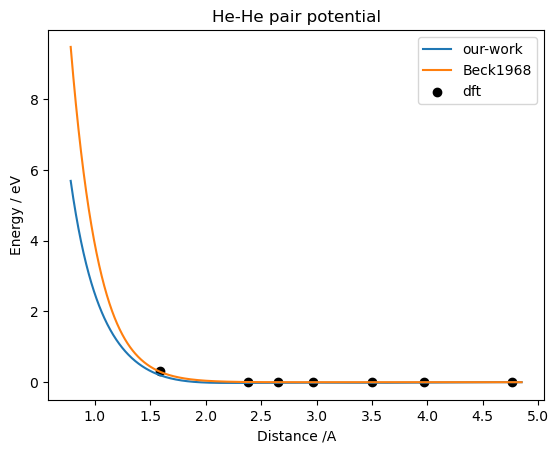

In [36]:
r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

dr = eam_fit.pot_params['rc']/eam_fit.pot_params['Nr']

phi = eam_fit.pot_lammps['He-He'][1:] / r

plt.plot(r[200:], phi[200:], label='our-work')

plt.plot(r[200:], Beck1968(r[200:]), label = 'Beck1968')

plt.scatter(pairwise_he_he[:,0], pairwise_he_he[:,1], label='dft', color='black')
plt.legend()
plt.title('He-He pair potential')

plt.xlabel('Distance /A')
plt.ylabel('Energy / eV')

In [37]:
# print(res.fun, res.x)

In [38]:
def eval_virial(phi, T_arr, r, dr):

    virial_coef = np.zeros(T_arr.shape)
    
    kb = 8.6173303e-5
    
    conv = 6.02214e-1

    for i, T in enumerate(T_arr):

        beta = 1 / (kb * T)

        y = ( 1 - np.exp(-beta * phi) ) * r**2

        virial_coef[i] = 2* np.pi * conv * simpson(y,x=r)

    return virial_coef

Text(0, 0.5, 'Virial Coefficient / eV')

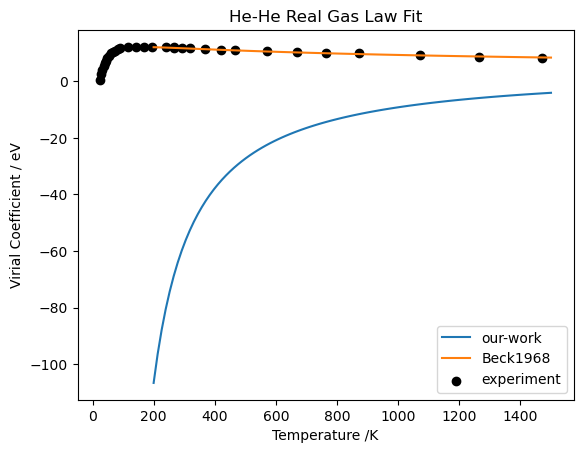

In [39]:
T_arr = np.linspace(200, 1500, 100)

virial_beck = eval_virial(Beck1968(r), T_arr, r, dr)

virial_pot = eval_virial(phi, T_arr,r, dr)

plt.plot(T_arr, virial_pot, label='our-work')

plt.plot(T_arr, virial_beck, label='Beck1968')

plt.scatter(virial_coef_he_he[:,0], virial_coef_he_he[:,1], color='black',label='experiment')

plt.legend()

plt.title('He-He Real Gas Law Fit')

plt.xlabel('Temperature /K')
plt.ylabel('Virial Coefficient / eV')

In [40]:
def loss_h_he(x, eam_fit, ref):

    loss = 0

    coef_dict = eam_fit.fit_sample(x)

    ZBL = EAM_Fitting_Serial.ZBL(2, 1)

    poly = EAM_Fitting_Serial.splineval(ref[:, 0], coef_dict['H-He'], eam_fit.knot_pts['H-He'])

    zbl = ZBL.eval_zbl(ref[:, 0])

    phi_pot = poly + zbl
    
    loss = np.sum((phi_pot - ref[:, 1])**2, axis=0)

    r_zbl = np.linspace(1.5, 2.25, 10)

    # loss += np.sum(EAM_Fitting_Serial.splineval(r_zbl, coef_dict['H-He'], eam_fit.knot_pts['H-He']) ** 2, axis = 0)

    return loss

def LJ(x, r):
    e = x[0]

    sigma = x[1]
    
    y = 4 * e * ((sigma/r)**12 - (sigma/r)**6)

    return y

def LJ_hhe(x, ref):

    y = LJ(x, ref[:, 0])
    
    loss = np.sum((1 - y/ref[:, 1])**2, axis=0)

    return loss

[5.8597846e-04 3.0000000e+00]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.22922565140055376
             x: [ 6.026e-04  3.059e+00]
           nit: 22
          nfev: 44
 final_simplex: (array([[ 6.026e-04,  3.059e+00],
                       [ 6.025e-04,  3.059e+00],
                       [ 6.024e-04,  3.059e+00]]), array([ 2.292e-01,  2.292e-01,  2.292e-01]))
[[ 2.64885000e+00  5.92872325e-03]
 [ 2.91373500e+00  1.38739018e-03]
 [ 3.17862000e+00 -3.86056397e-04]
 [ 3.44350500e+00 -5.48062207e-04]
 [ 3.70839000e+00 -5.85978460e-04]
 [ 3.97327500e+00 -4.22249185e-04]
 [ 4.23816000e+00 -3.75715601e-04]
 [ 4.76793000e+00 -1.68037941e-04]]


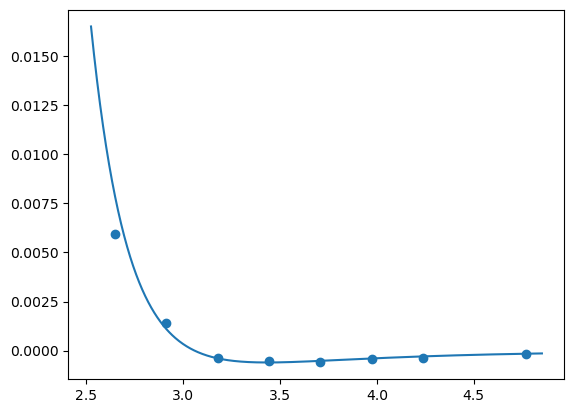

In [41]:
x0 = np.array([ abs(pairwise_h_he[:,1].min()), 3])
print(x0)

lj_res = minimize(LJ_hhe, x0, args=(pairwise_h_he), method='Nelder-Mead')

r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[650:]

print(lj_res)

plt.plot(r, LJ(lj_res.x, r))

plt.scatter(pairwise_h_he[:,0], pairwise_h_he[:,1])

print(pairwise_h_he)

In [42]:
n_knots = {}
n_knots['He_F'] = 0
n_knots['He_p'] = 0
n_knots['W-He'] = 0
n_knots['He-He'] = 0
n_knots['H-He'] = 4

eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

knot_pts = eam_fit.knot_pts['H-He'][1:-1]

zbl = zbl_hehe.eval_zbl(knot_pts)
zbl_grad = zbl_hehe.eval_grad(knot_pts)
zbl_hess = zbl_hehe.eval_hess(knot_pts)


h = 1e-4

lj = LJ(lj_res.x, knot_pts)
lj_grad = (LJ(lj_res.x, knot_pts + h) -   LJ(lj_res.x, knot_pts))/ h
lj_hess = (LJ(lj_res.x, knot_pts + h) - 2*LJ(lj_res.x, knot_pts) + LJ(lj_res.x ,knot_pts - h))/ h**2


zbl_arr = []
lj_arr = []

for i in range(len(knot_pts)):
    zbl_arr.append([zbl[i], zbl_grad[i], zbl_hess[i]])
    lj_arr.append([lj[i], lj_grad[i], lj_hess[i]])

zbl_arr = np.array(zbl_arr).flatten()
lj_arr = np.array(lj_arr).flatten()

sample = lj_arr - zbl_arr

print(sample)

sample[:3] = 0

sample = np.array([-1.875e-01,  2.568e-01, -2.578e-01, -1.852e-02,  2.622e-02, -3.972e-02])
# [-2.672e-02 -1.622e-01  4.671e-01 -1.844e-02  2.524e-02
#                  -3.426e-02]

# sample = np.array([-4.853100713519482579e-01, 1.150823606429474122e+00, -4.976544410902667082e+00, 9.532997748484475231e-01, 5.109644441615284194e+00,4.298031864389798784e+00])
loss_h_he(sample, eam_fit, pairwise_h_he)

[ 4.36380236e+00 -3.57605083e+01  2.96511797e+02 -2.69804274e-02
  4.09368661e-02 -6.40468042e-02]


7.472713921003262e-08

In [43]:
res = minimize(loss_h_he, sample + 1e-1*np.random.random(sample.shape), args=(eam_fit, pairwise_h_he), method='Nelder-Mead')

print(res)

eam_fit.sample_to_file(res.x)

sample = np.array([0.05929112 ,-0.55305783 ,-2.0343342, -0.10391206, -0.03171282,  1.38188588])

eam_fit.sample_to_file(sample)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.284441462002122e-08
             x: [-7.367e-01  2.051e+00 -4.832e+00 -1.854e-02  2.762e-02
                 -4.968e-02]
           nit: 598
          nfev: 958
 final_simplex: (array([[-7.367e-01,  2.051e+00, ...,  2.762e-02,
                        -4.968e-02],
                       [-7.367e-01,  2.051e+00, ...,  2.762e-02,
                        -4.969e-02],
                       ...,
                       [-7.367e-01,  2.051e+00, ...,  2.762e-02,
                        -4.968e-02],
                       [-7.367e-01,  2.051e+00, ...,  2.762e-02,
                        -4.968e-02]]), array([ 4.284e-08,  4.284e-08,  4.284e-08,  4.284e-08,
                        4.284e-08,  4.284e-08,  4.284e-08]))


-0.11568868554430019 2.3344153249959967 -0.0005859784603999999


Text(0, 0.5, 'Energy / eV')

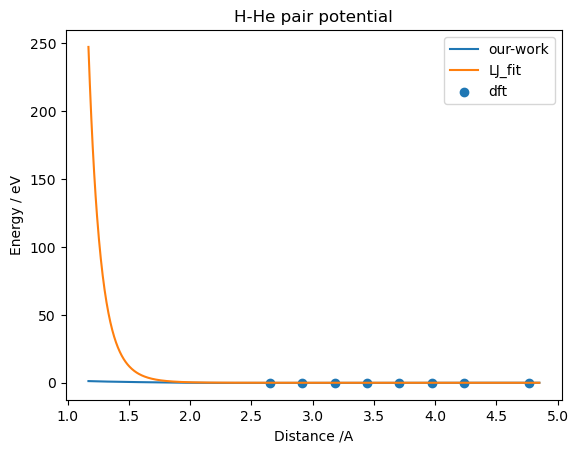

In [44]:
r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

dr = eam_fit.pot_params['rc']/eam_fit.pot_params['Nr']

phi = eam_fit.pot_lammps['H-He'][1:] / r

plt.plot(r[300:], phi[300:], label='our-work')

plt.plot(r[300:], LJ(lj_res.x, r[300:]), label='LJ_fit')

plt.scatter(pairwise_h_he[:,0], pairwise_h_he[:,1], label='dft')

plt.legend()

print(phi.min(), r[phi.argmin()], pairwise_h_he[:,1].min())

plt.title('H-He pair potential')

plt.xlabel('Distance /A')
plt.ylabel('Energy / eV')

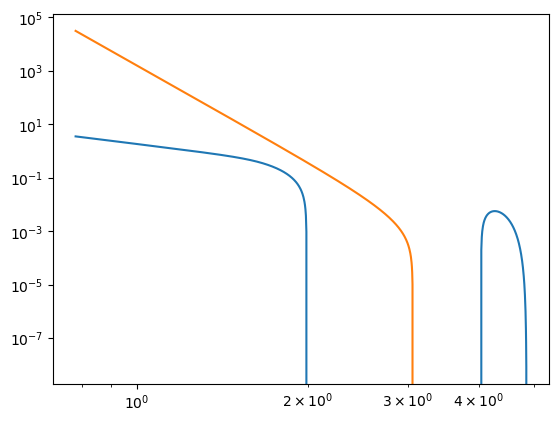

In [45]:
plt.loglog(r[200:], phi[200:])
plt.loglog(r[200:], LJ(lj_res.x, r[200:]))

[ 0.893065    0.00591913 -0.28502528  0.00525894  0.8646166 ]
0 4.773959005888173e-15


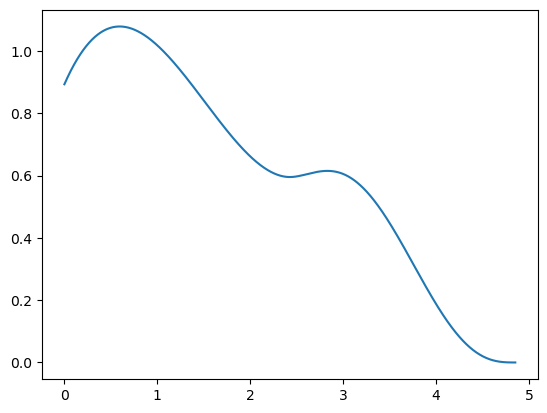

In [46]:
def gauss(x, A, sigma):
    return A * np.exp(-0.5*(x/sigma)**2)

def dgauss(x, A, sigma):
    return - (A * x / sigma ** 2) * np.exp(-0.5*(x/sigma)**2)

def d2gauss(x, A, sigma):
    return (A / sigma ** 4) * (x**2 - sigma**2) * np.exp(-0.5*(x/sigma)**2)


def exp(x, A, b):
    return A * np.exp(-b * x)

def dexp(x, A, b):
    return -b * A * np.exp(-b * x)

def d2exp(x, A, b):
    return b**2 * A * np.exp(-b * x)

n_knots = {}
n_knots['He_F'] = 0
n_knots['He_p'] = 3
n_knots['W-He'] = 0
n_knots['He-He'] = 0
n_knots['H-He'] = 0


eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

knot_pts = eam_fit.knot_pts['He_p'][1:-1]
r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])

A = 1

sigma = 1

y_gauss = gauss(r, A, sigma)

p = np.polyfit(r, y_gauss, 10)

y_poly = np.polyval(p, r)

# sample = [A,sigma]

# for _pt in knot_pts:
    # sample.extend([gauss(_pt, A, sigma), dgauss(_pt, A, sigma), d2gauss(_pt, A, sigma)])
    # sample.extend([0, 0, 0])

# sample = np.array(sample)

# sample =  5e-1 * (np.random.random(len(knot_pts) * 3) - 0.5)

# sample = np.hstack([A, sigma, sample])

sample = eam_fit.gen_rand()

print(sample)

coef_dict = eam_fit.fit_sample(sample)

y = EAM_Fitting_Serial.splineval(r, coef_dict['He_p'], eam_fit.knot_pts['He_p']) + exp(r, sample[0], sample[1])

plt.plot(r, y)

loss = 0 

sort_idx = np.argsort(y)

if (y < -1e-3).any():
    loss += 1000


print(loss, y.min())

In [47]:
def loss_w_he(x, eam_fit, ref):

    loss = 0

    coef_dict = eam_fit.fit_sample(x)

    ZBL = EAM_Fitting_Serial.ZBL(2, 74)

    poly = EAM_Fitting_Serial.splineval(ref[:, 0], coef_dict['W-He'], eam_fit.knot_pts['W-He'])

    zbl = ZBL.eval_zbl(ref[:, 0])

    phi_pot = poly + zbl
    
    loss = np.sum((phi_pot - ref[:, 1])**2, axis=0)

    poly = EAM_Fitting_Serial.splineval(np.linspace(1,2.25,10), coef_dict['W-He'], eam_fit.knot_pts['W-He'])

    loss += 0.1*np.sum(poly **2, axis = 0)

    return loss

In [48]:
n_knots = {}
n_knots['He_F'] = 0
n_knots['He_p'] = 0
n_knots['W-He'] = 4
n_knots['He-He'] = 0
n_knots['H-He'] = 0

eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

knot_pts = eam_fit.knot_pts['W-He'][1:-1]

zbl = zbl_whe.eval_zbl(knot_pts)
zbl_grad = zbl_whe.eval_grad(knot_pts)
zbl_hess = zbl_whe.eval_hess(knot_pts)


h = 1e-4

lj_res.x = np.array([5e-3, 3])

lj = LJ(lj_res.x, knot_pts)
lj_grad = (LJ(lj_res.x, knot_pts + h) -   LJ(lj_res.x, knot_pts))/ h
lj_hess = (LJ(lj_res.x, knot_pts + h) - 2*LJ(lj_res.x, knot_pts) + LJ(lj_res.x ,knot_pts - h))/ h**2

ref_whe = np.column_stack([np.linspace(2.5, 4.5, 20), LJ(lj_res.x, np.linspace(2.5,4.5, 20))])

zbl_arr = []
lj_arr = []

for i in range(len(knot_pts)):
    zbl_arr.append([zbl[i], zbl_grad[i], zbl_hess[i]])
    lj_arr.append([lj[i], lj_grad[i], lj_hess[i]])

zbl_arr = np.array(zbl_arr).flatten()
lj_arr = np.array(lj_arr).flatten()

sample = lj_arr - zbl_arr

sample = np.array([-3.652e-01 , -2.126e-01 , -2.837e-02 , -9.380e-02 , 1.733e-01 , -3.249e-01])

eam_fit.sample_to_file(sample)

loss_w_he(sample, eam_fit, ref_whe)

0.2167912609963304

In [49]:
res = minimize(loss_w_he, sample + (np.random.random(sample.shape) - 0.5), args=(eam_fit, ref_whe), method='Nelder-Mead', options={'maxiter':10000})

print(res)

eam_fit.sample_to_file(res.x)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0031513549456010457
             x: [ 2.218e-02  3.095e-01  1.182e+00 -2.421e-01  4.559e-01
                 -8.418e-01]
           nit: 968
          nfev: 1508
 final_simplex: (array([[ 2.218e-02,  3.095e-01, ...,  4.559e-01,
                        -8.418e-01],
                       [ 2.218e-02,  3.095e-01, ...,  4.559e-01,
                        -8.418e-01],
                       ...,
                       [ 2.218e-02,  3.095e-01, ...,  4.559e-01,
                        -8.417e-01],
                       [ 2.218e-02,  3.095e-01, ...,  4.559e-01,
                        -8.418e-01]]), array([ 3.151e-03,  3.151e-03,  3.151e-03,  3.151e-03,
                        3.151e-03,  3.151e-03,  3.151e-03]))


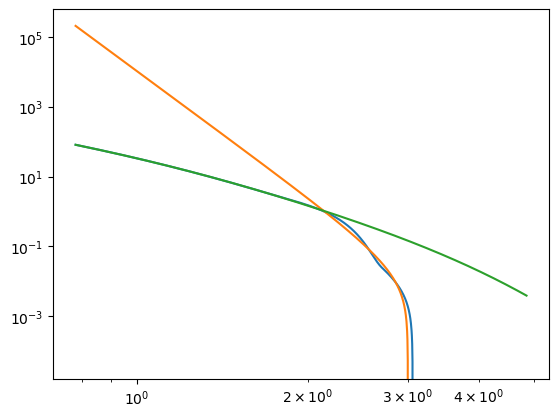

In [50]:
r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

dr = eam_fit.pot_params['rc']/eam_fit.pot_params['Nr']

phi = eam_fit.pot_lammps['W-He'][1:] / r

plt.loglog(r[200:], phi[200:], label='our-work')

plt.loglog(r[200:], LJ(lj_res.x, r[200:]))

plt.loglog(r[200:], zbl_whe.eval_zbl(r[200:]))

-0.005176812075829901


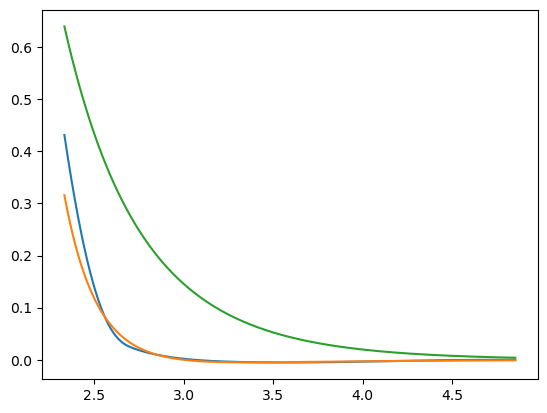

In [51]:

plt.plot(r[600:], phi[600:], label='our-work')

plt.plot(r[600:], LJ(lj_res.x, r[600:]))

plt.plot(r[600:], zbl_whe.eval_zbl(r[600:]))

print(phi.min())

[ 0.        0.3      19.792116]


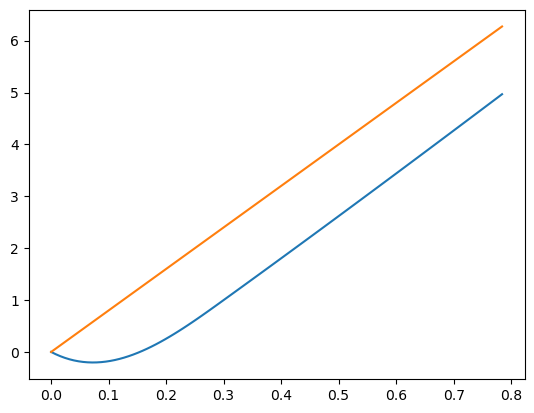

In [80]:
n_knots = {}
n_knots['He_F'] = 3
n_knots['He_p'] = 0
n_knots['W-He'] = 0
n_knots['He-He'] = 0
n_knots['H-He'] = 0


eam_fit = EAM_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

sample = np.array([0, 1, 8, 1])

# rsample = eam_fit.gen_rand()

eam_fit.sample_to_file(sample)

r = np.linspace(0, eam_fit.pot_params['rho_c'], eam_fit.pot_params['Nrho'])

plt.plot(r[:100], eam_fit.pot_lammps['He_F'][:100])
plt.plot(r[:100], 8*r[:100])

print(eam_fit.knot_pts['He_F'])
# print(rsample)

[ 0.         -0.03100325 -0.06036573 -0.08813193 -0.11434636]


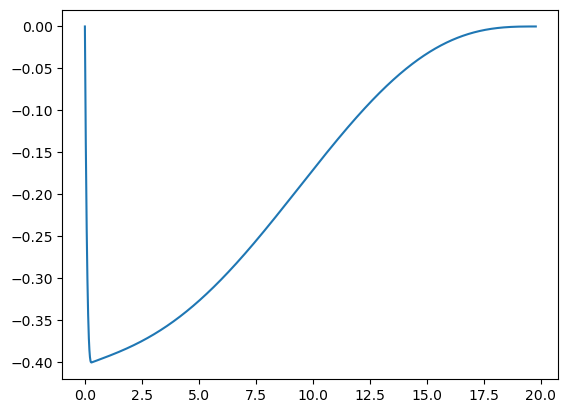

In [53]:
coef_dict = eam_fit.fit_sample(sample)

y = EAM_Fitting_Serial.splineval(r, coef_dict['He_F'], eam_fit.knot_pts['He_F'])

plt.plot(r,y)

print(y[:5])

(array([], dtype=int64), {})


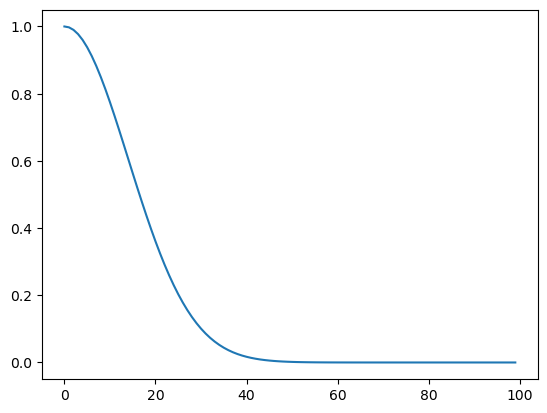

In [54]:
y = np.exp(-np.linspace(0,5, 100)**2)
from scipy.signal import find_peaks
print(find_peaks(y))
plt.plot(y)